In [1]:
import re
from sklearn.datasets import load_files
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
figSize = (10,8)
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Utility functions to clean text

In [2]:
def removeSpecialChars(sen):
    theSentence = re.sub(r'\W', ' ', str(sen))
    return theSentence

In [3]:
def removeSingleChars(sen):
    theSentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sen)
    theSentence = re.sub(r'\^[a-zA-Z]\s+', ' ', theSentence) #remove from the start
    return theSentence

In [4]:
def substitutingSpaces(sen):
    theSentence = re.sub(r'\s+', ' ', sen, flags=re.I)
    return theSentence

In [5]:
def removeProfix_b(sen):
    theSentence = re.sub(r'^b\s+', '',sen)
    return theSentence

In [6]:
def convertToLowecase(sen):
    theSentence = sen.lower()
    return theSentence

In [7]:
def lemmatization(sen):
    stemmer = WordNetLemmatizer()
    theSentence = sen.split()
    theSentence = [stemmer.lemmatize(word) for word in theSentence]
    theSentence = ' '.join(theSentence)
    return theSentence

In [8]:
def cleanTheSentence(sen):
    theSentence = removeSpecialChars(sen)
    theSentence = removeSpecialChars(theSentence)
    theSentence = substitutingSpaces(theSentence)
    theSentence = removeProfix_b(theSentence)
    theSentence = convertToLowecase(theSentence)
    theSentence = lemmatization(theSentence)

    return theSentence

In [9]:
def loadDataFile(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

## Loading data and see text before and after cleaning

In [10]:
movie_data = load_files("txt_sentoken")
X, y = movie_data.data, movie_data.target
print(X[0],y[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \r\nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \r\nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \r\nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \r\nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \r\nparts of this are actually so absurd , that they would fit right in with dogma . \r\nyes , 

In [11]:
documents = []

for sen in range(0, len(X)):
    CleanSentence = cleanTheSentence(X[sen])
    documents.append(CleanSentence)
print(documents[0],"Target : "+str(y[0]))

arnold schwarzenegger ha been an icon for action enthusiast since the late 80 s but lately his film have been very sloppy and the one liner are getting worse r nit s hard seeing arnold a mr freeze in batman and robin especially when he say ton of ice joke but hey he got 15 million what s it matter to him r nonce again arnold ha signed to do another expensive blockbuster that can t compare with the like of the terminator series true lie and even eraser r nin this so called dark thriller the devil gabriel byrne ha come upon earth to impregnate a woman robin tunney which happens every 1000 year and basically destroy the world but apparently god ha chosen one man and that one man is jericho cane arnold himself r nwith the help of a trusty sidekick kevin pollack they will stop at nothing to let the devil take over the world r nparts of this are actually so absurd that they would fit right in with dogma r nyes the film is that weak but it s better than the other blockbuster right now sleepy 

In [12]:
df = pd.DataFrame({'review':documents,'class':y})
df.head()

,review,class
0,arnold schwarzenegger ha been an icon for acti...,0
1,good film are hard to find these day r ngreat ...,1
2,quaid star a a man who ha taken up the proffes...,1
3,we could paraphrase michelle pfieffer s charac...,0
4,kolya is one of the richest film i ve seen in ...,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  2000 non-null   object
 1   class   2000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 23.6+ KB


Data set have no null values

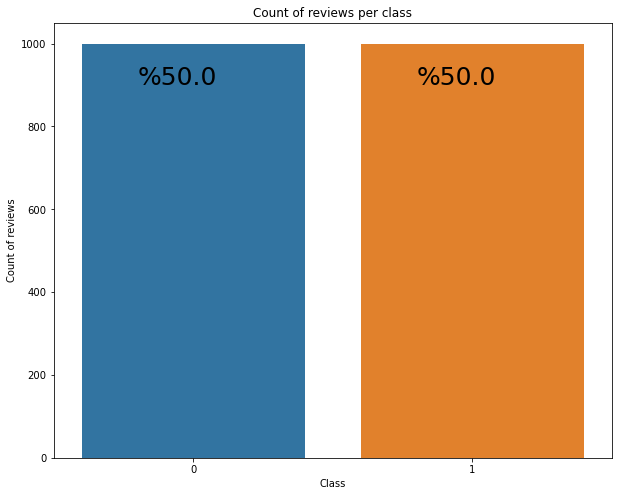

In [14]:
# Representation of both classes
plt.figure(figsize=figSize)
ax = sns.countplot(x='class', data=df)
plt.title('Count of reviews per class')
plt.xlabel('Class')
plt.ylabel('Count of reviews')

for p in ax.patches:
        ax.annotate('%{:.1f}'.format(p.get_height()/df.shape[0]*100), (p.get_x()+0.2, p.get_height()-100),fontsize = 25)

Both classes are reperesented equally

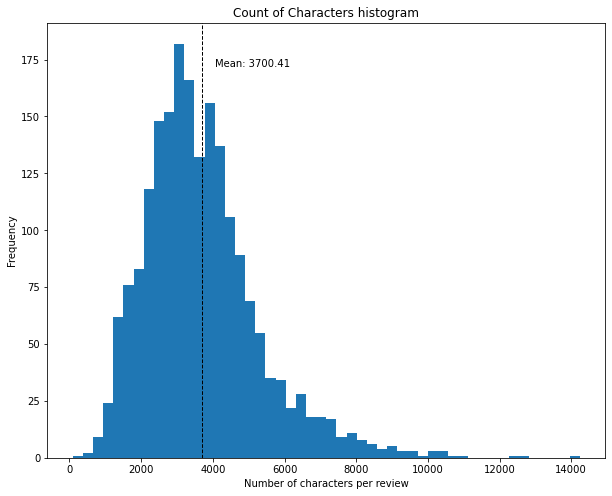

In [15]:
plt.figure(figsize = figSize)
plt.hist(df['review'].str.len(),bins=50);
plt.xlabel('Number of characters per review')
plt.title('Count of Characters histogram')
plt.ylabel('Frequency')
plt.axvline(df['review'].str.len().mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df['review'].str.len().mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df['review'].str.len().mean()))
plt.show();

Number of characters per review are positively skewed with mean of ~ 3700 character per review.

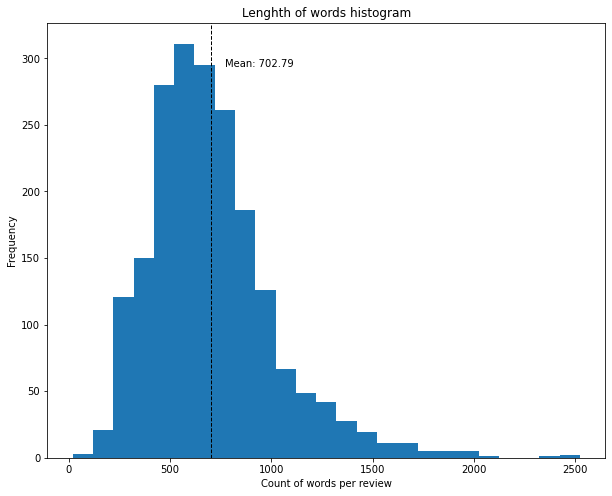

In [16]:
plt.figure(figsize = figSize)
plt.hist(df['review'].apply(lambda x:len(x.split())),bins = 25);
plt.xlabel('Count of words per review')
plt.title('Lenghth of words histogram')
plt.ylabel('Frequency')
plt.axvline(df['review'].apply(lambda x:len(x.split())).mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df['review'].apply(lambda x:len(x.split())).mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df['review'].apply(lambda x:len(x.split())).mean()))
plt.show();

Number of words per review is positively skewed with mean of ~ 708 words per review.

## Most frequent stop words in reviews 

In [17]:
stop = set(stopwords.words('english'))
reviews = df['review'].str.split()
from collections import defaultdict
dic = defaultdict(int)
for review in reviews:
    for word in review:
        if word in stop:
            dic[word]+=1
dic = sorted(dic.items(),key=lambda item: item[1],reverse=True)[0:10]


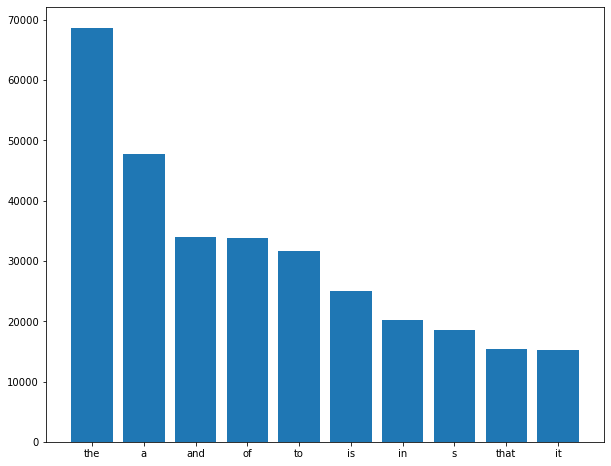

In [18]:
plt.figure(figsize = figSize)
plt.bar(x=[x[0] for x in dic],height = [y[1] for y in dic])
plt.show();

## Most frequent non-stop words in reviews 

In [19]:
stop = set(stopwords.words('english'))
reviews = df['review'].str.split()
from collections import defaultdict
dic = defaultdict(int)
for review in reviews:
    for word in review:
        if word not in stop and word != 'n' and word !='r': # ns and rs are spaces so i didn't count them
            dic[word]+=1
dic2 = sorted(dic.items(),key=lambda item: item[1],reverse=True)[0:10]
dic2

[('film', 11031),
 ('nthe', 7810),
 ('movie', 6943),
 ('one', 5548),
 ('wa', 4909),
 ('ha', 4743),
 ('character', 3858),
 ('like', 3633),
 ('nit', 3096),
 ('time', 2969)]

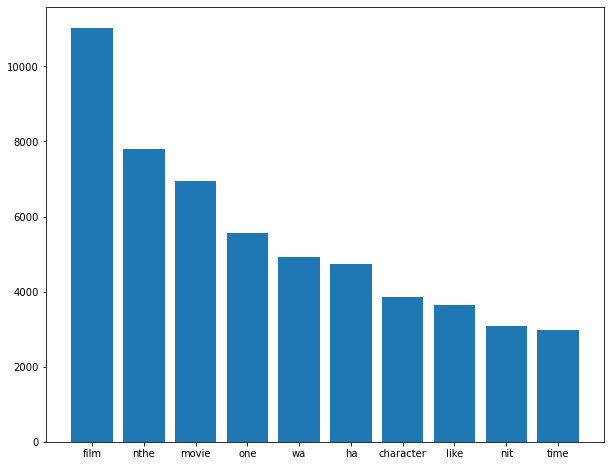

In [20]:
plt.figure(figsize = figSize)
plt.bar(x=[x[0] for x in dic2],height = [y[1] for y in dic2])
plt.show();

In [21]:
# vectorize reviews with Tf-df vectorizer to perepare them for classification
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()

## Classification with RandomForest classifier

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
clf = RandomForestClassifier(n_estimators=1000, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("classification_report ",classification_report(y_test, y_pred,target_names = ['negative','positive']))

classification_report                precision    recall  f1-score   support

    negative       0.86      0.87      0.86       208
    positive       0.85      0.84      0.85       192

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



In [24]:
print("accuracy = ",accuracy_score(y_test, y_pred))

accuracy =  0.855


In [25]:
print("confusion_matrix ",  confusion_matrix(y_test,y_pred))

confusion_matrix  [[180  28]
 [ 30 162]]


In [26]:
print('enter path of new input') #Input.txt
s = input()
Inp = loadDataFile(s)
Inp = [cleanTheSentence(Inp)]
Inp = tfidfconverter.transform(Inp)
print("input classified as ",clf.predict(Inp)[0])

enter path of new input
Input.txt
input classified as  1


## Classification with LogisticRegression classifier


In [27]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("classification_report ",classification_report(y_test, y_pred,target_names = ['negative','positive']))


classification_report                precision    recall  f1-score   support

    negative       0.86      0.81      0.83       208
    positive       0.80      0.85      0.83       192

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [28]:
print("accuracy = ",accuracy_score(y_test, y_pred))

accuracy =  0.83


In [29]:
print("confusion_matrix ",  confusion_matrix(y_test,y_pred))

confusion_matrix  [[168  40]
 [ 28 164]]


In [30]:
print('enter path of new input') #Input.txt
s = input()
Inp = loadDataFile(s)
Inp = [cleanTheSentence(Inp)]
Inp = tfidfconverter.transform(Inp)
print("input classified as ",clf.predict(Inp)[0])

enter path of new input
Input.txt
input classified as  1


Both classifiers were able to classify input review correctly but random forrest was better to generalize.